In [7]:
from flight_controller import FlightController
import pygame
import numpy as np

In [3]:
def generate_controller() -> FlightController:
    # return HeuristicController() # <--- Replace this with your own written controller
    return CustomController()


In [ ]:
pygame.init()
clock = pygame.time.Clock()

# Load the relevant graphics into pygame
drone_img = pygame.image.load('graphics/drone_small.png')
background_img = pygame.image.load('graphics/background.png')
target_img = pygame.image.load('graphics/target.png')

# Create the screen
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

# Initalise the drone
drone = controller.init_drone()

simulation_step_counter = 0
max_simulation_steps = controller.get_max_simulation_steps()
delta_time = controller.get_time_interval()

In [1]:
import numpy as np
from flight_controller import FlightController

class DQNController(FlightController):
    def __init__(self):
        super().__init__()
        # Initialize parameters such as learning rate, discount factor, neural network layers, etc.
        # Initialize experience replay memory
        # Initialize the neural network for the Q-function
        pass

    def discretize_action_space(self, num_actions_per_propeller):
        # Discretize the action space for both propellers
        pass

    def build_model(self):
        # Build the neural network model for the Q-function
        pass

    def get_state(self, drone):
        # Return the current state of the drone
        pass

    def get_reward(self, drone):
        # Return the current reward
        pass

    def remember(self, state, action, reward, next_state, done):
        # Store experience in replay memory
        pass

    def replay(self, batch_size):
        # Sample a minibatch from the replay memory
        # Perform the Q-learning update
        pass

    def train(self, episodes):
        # Training loop over episodes
        pass

    def act(self, state, epsilon):
        # Select an action using epsilon-greedy policy
        pass

    # Implement other necessary methods inherited from FlightController


In [ ]:
def generate_action_space():
    actions = []
    for param1 in np.linspace(min_param1, max_param1, num_steps):
        for param2 in np.linspace(min_param2, max_param2, num_steps):
            # ... include other parameters if necessary
            thrust_left1, thrust_right1 = heuristic1(param1, param2, ...)
            thrust_left2, thrust_right2 = heuristic2(param1, param2, ...)
            actions.append((thrust_left1, thrust_right1))
            actions.append((thrust_left2, thrust_right2))
    return np.array(actions)

In [9]:
def discretize_action_space(num_actions_per_propeller):
    # Create a grid of actions based on the number of actions for each propeller
    action_grid = np.linspace(0, 1, num_actions_per_propeller)
    discrete_actions = np.array(np.meshgrid(action_grid, action_grid)).T.reshape(-1, 2)
    return discrete_actions

In [11]:
x = discretize_action_space(2)

In [12]:
x [2] 

array([1., 0.])

In [ ]:
batch_size = 64
memory = []
memory.append()
minibatch = np.random.choice(self.memory, batch_size, replace=False)

In [17]:
w2 = np.ones(1024)
w2.shape

(1024,)

In [19]:
np.hypot(0.35,0.3)

0.4609772228646443

In [28]:
filename = "dqn_controller_499.npz"
data = np.load(filename)

In [29]:
data['w1']

array([[ 3.68471928e-01,  1.34098525e-01,  1.36643214e-01,
        -9.45290934e-02,  6.53291851e-01, -2.00746030e-01,
         3.99629919e-02,  4.17145901e-01, -1.56808063e-03,
        -1.69935502e-01, -1.05858418e-01,  3.90307832e-01,
         1.47967219e-01, -9.33298183e-01, -3.87695422e-01,
        -1.27833146e-01,  6.86555885e-01,  3.56303373e-02,
        -1.44899436e-01,  7.31091320e-03, -5.87237703e-02,
         5.39259678e-01, -4.96607894e-01, -1.69127317e-01,
        -1.23286404e-01,  3.83581357e-01, -3.54062958e-01,
         1.16249537e-01,  4.10305547e-01,  5.24260514e-01,
         4.46120821e-02,  5.58025363e-01,  1.58037806e-01,
         3.96084487e-01, -2.59020625e-01, -8.72297815e-01,
         3.06712939e-03,  1.77427905e-02,  3.46754097e-01,
        -7.35070614e-01,  6.50926628e-01,  4.58297779e-02,
        -1.82642233e-01,  5.03826137e-01,  5.00188365e-01,
        -3.53316230e-01, -6.58620860e-02, -8.09764088e-01,
         2.35157548e-02,  3.24471783e-01,  1.03488154e-0

In [30]:
data['b1']

array([-0.44181918,  0.49566073, -0.46245834,  0.54234389, -0.43064127,
        0.39537497, -0.45559902,  0.52551377, -0.48119079,  0.32106523,
       -0.50844914, -0.33030212,  0.51394851,  0.58351298, -0.43359342,
       -0.404772  ,  0.48153569,  0.41440077, -0.47941746,  0.49570074,
        0.48696124, -0.44721567, -0.57776672,  0.47022657,  0.44211737,
        0.39330425,  0.48678993,  0.45327411, -0.46791891,  0.30411593,
        0.5433346 , -0.33485174, -0.29318832, -0.52607254, -0.40290316,
        0.5056517 ,  0.47797432,  0.33606334,  0.44599865,  0.42560257,
       -0.47381125, -0.41343457, -0.42622153,  0.58883538,  0.52384287,
        0.42513539, -0.49396128, -0.56768955, -0.33255813, -0.52247385,
        0.37944999, -0.39055255,  0.46354302,  0.44649857, -0.51842971,
        0.4786343 , -0.51445079, -0.38100643, -0.34751928, -0.49536941,
       -0.44959418, -0.49283502,  0.37923996,  0.48507157])

In [27]:
data['b2']

array([-0.42619887, -0.40923792, -0.36935284, -0.41831957, -0.44610325,
       -0.38959524, -0.37447773, -0.44986079, -0.43617697, -0.43594939,
       -0.37211674, -0.40788847, -0.43477762, -0.37065838, -0.36636624,
       -0.41744433, -0.436814  , -0.41148581, -0.40619235, -0.38799329,
       -0.40750848, -0.41081867, -0.44902122, -0.4518155 , -0.41529669,
       -0.39138591, -0.42665881, -0.38255736, -0.39774139, -0.42704555,
       -0.40278087, -0.43033491, -0.41026235, -0.41605719, -0.38840719,
       -0.39468674, -0.37956541, -0.43905353, -0.42839933, -0.45770487,
       -0.3730689 , -0.39241086, -0.4085443 , -0.45293867, -0.41979978,
       -0.35404442, -0.37434141, -0.44279388, -0.4452656 , -0.3862494 ,
       -0.44755183, -0.4406498 , -0.3997214 , -0.40457149, -0.39683895,
       -0.4332995 , -0.44691523, -0.44948867, -0.43945538, -0.41504004,
       -0.45537439, -0.42161204, -0.42230325, -0.41242533])

In [31]:
state_size = 10
action_size = 4
q_values = np.zeros((state_size, action_size))


In [33]:
q_values[4]

array([0., 0., 0., 0.])

In [ ]:
import numpy as np

class Drone():
    # ... existing methods ...

    def get_state(self):
        # Define the discretization steps for each component
        position_step = 1.0  # e.g., 1 unit of space
        velocity_step = 0.5  # e.g., 0.5 units of velocity
        pitch_step = np.pi / 18  # e.g., 10 degrees

        # Discretize each component
        discretized_x = int(self.x / position_step)
        discretized_y = int(self.y / position_step)
        discretized_velocity_x = int(self.velocity_x / velocity_step)
        discretized_velocity_y = int(self.velocity_y / velocity_step)
        discretized_pitch = int(self.pitch / pitch_step)

        # Combine into a single state
        state = (discretized_x, discretized_y, discretized_velocity_x, discretized_velocity_y, discretized_pitch)
        return state

In [46]:
filename = "heuristic_controller_parameters.npy"
data = np.load(filename)

In [47]:
data

array([1.10526316, 3.        , 0.1       , 0.3       ])

In [69]:
import json

# Load the parameters from the JSON file
with open('heuristic_controller_2_parameters.json', 'r') as file:
    parameters = json.load(file)

# # Display the contents
# print("Loaded Parameters:")
# for param, value in parameters.items():
#     print(f"{param}: {value}")

In [70]:
for param in parameters:
    print(param)

{'episode': 1, 'performance': -5.646779525451077, 'parameters': {'k': 10.0, 'b': 0.3, 'k_theta': 10.0, 'b_theta': 0.3}}
{'episode': 251, 'performance': -5.549699211272591, 'parameters': {'k': 1.0, 'b': 0.3, 'k_theta': 2.75, 'b_theta': 0.3}}
{'episode': 701, 'performance': -5.432897079859952, 'parameters': {'k': 1.0, 'b': 0.3, 'k_theta': 6.25, 'b_theta': 0.3}}
{'episode': 1051, 'performance': -5.368034072277387, 'parameters': {'k': 1.0, 'b': 0.3, 'k_theta': 5.25, 'b_theta': 0.3}}
{'episode': 2251, 'performance': -5.3633032731491115, 'parameters': {'k': 1.0, 'b': 0.3, 'k_theta': 4.75, 'b_theta': 0.3}}
{'episode': 4251, 'performance': -5.204134678776716, 'parameters': {'k': 8.25, 'b': 0.3, 'k_theta': 9.5, 'b_theta': 0.3}}


In [67]:
best_param_heuristic_2 = {'k': 3.75, 'b': 0.3, 'k_theta': 2.25, 'b_theta': 0.3, 'theta_target': 7}
best_param_heuristic_1 = {'ky': 3, 'kx': 2.6, 'abs_pitch_delta': 0.1, 'abs_thrust_delta':0.4}

In [68]:
best_param_heuristic_2['k']

3.75

In [71]:
parameters_dict = {'k': 8.25, 'b': 0.3, 'k_theta': 9.5, 'b_theta': 0.3, 'theta_target': 7}
# Convert dictionary to array in the correct order
parameters_array = np.array([parameters_dict['k'],
                              parameters_dict['b'],
                                parameters_dict['k_theta'],
                                  parameters_dict['b_theta'],
                                  parameters_dict['theta_target']])

# Save the array to a file
np.save('heuristic_controller_parameters_2.npy', parameters_array)


In [ ]:
def get_state(target_):

    target_point = drone.get_next_target()
    dx = target_point[0] - drone.x
    dy = target_point[1] - drone.y

    # Define the discretization steps for each component
    step_size = 0.25  # e.g., 1 unit of space
    pitch_step = np.pi / 9  # e.g., 10 degrees

    # Discretize each component with clamping
    discretized_x = self.discretize_with_clamp(dx, -0.5, 0.5, step_size)
    discretized_y = self.discretize_with_clamp(dy, -0.5, 0.5, step_size)
    discretized_velocity_y = self.discretize_with_clamp(drone.velocity_y, -0.5, 0.5, step_size)
    discretized_pitch = self.discretize_with_clamp(drone.pitch, -0.5, 0.5, pitch_step)
    discretized_pitch_velocity = self.discretize_with_clamp(drone.pitch_velocity, -1, 1, step_size)


    # print(discretized_x,
    #       discretized_y,
    #       discretized_velocity_y,
    #       discretized_pitch,
    #       discretized_pitch_velocity,
    #       discretized_target_x,
    #       discretized_target_y)
    # Combine into a single state index
    state_index = (discretized_x +
                    discretized_y * 5 +
                    discretized_velocity_y * 5**2 +
                    discretized_pitch * 5**2 * 5 +
                    discretized_pitch_velocity * 5**2 * 5 * 6 +
                    discretized_target_x * 5**2 * 5 * 6 * 9 +
                    discretized_target_y * 5**3 * 5 * 6 * 9)
    return state_index

In [76]:
import json

# Load the parameters from the JSON file
with open('./Results/tuning/all_best_parameters_heuristic_2.json', 'r') as file:
    data = json.load(file)

sorted_data = sorted(data, key=lambda x: x['performance'], reverse=True)
top_3_parameters = sorted_data[:3]


In [78]:

for i, entry in enumerate(top_3_parameters, 1):
    print(f"Top {i}:")
    print(f"Episode: {entry['episode']}")
    print(f"Performance: {entry['performance']}")
    print(f"Parameters: {entry['parameters']}")
    print(f"Hyperparameters: {entry['hyperparameters']}\n")

Top 1:
Episode: 601
Performance: -5.023171438066489
Parameters: {'k': 1.0, 'b': 0.5499999999999997, 'k_theta': 8.0, 'b_theta': 0.1}
Hyperparameters: {'learning_rate': 0.05, 'discount_factor': 0.8, 'epsilon_decay': 0.99}

Top 2:
Episode: 421
Performance: -5.155772700294333
Parameters: {'k': 3.0, 'b': 0.2499999999999997, 'k_theta': 9.0, 'b_theta': 0.175}
Hyperparameters: {'learning_rate': 0.1, 'discount_factor': 0.8, 'epsilon_decay': 0.99}

Top 3:
Episode: 961
Performance: -5.273813934214886
Parameters: {'k': 6.5, 'b': 0.2500000000000001, 'k_theta': 8.0, 'b_theta': 0.1}
Hyperparameters: {'learning_rate': 0.1, 'discount_factor': 0.9, 'epsilon_decay': 0.9}



In [79]:
with open('./Results/tuning/all_best_parameters_heuristic_1.json', 'r') as file:
    data_h1 = json.load(file)

sorted_h1_data = sorted(data_h1, key=lambda x: x['performance'], reverse=True)
top_3_h1_params = sorted_h1_data[:3]

In [80]:
for i, entry in enumerate(top_3_h1_params, 1):
    print(f"Top {i}:")
    print(f"Episode: {entry['episode']}")
    print(f"Performance: {entry['performance']}")
    print(f"Parameters: {entry['parameters']}")
    print(f"Hyperparameters: {entry['hyperparameters']}\n")

Top 1:
Episode: 631
Performance: -4.863368763528116
Parameters: {'ky': 2.5500000000000003, 'kx': 0.7999999999999993, 'abs_pitch_delta': 0.10000000000000003, 'abs_thrust_delta': 0.5}
Hyperparameters: {'learning_rate': 0.05, 'discount_factor': 0.9, 'epsilon_decay': 0.9}

Top 2:
Episode: 1051
Performance: -4.9376116341312075
Parameters: {'ky': 2.7, 'kx': 1.5000000000000004, 'abs_pitch_delta': 0.10000000000000005, 'abs_thrust_delta': 0.44999999999999996}
Hyperparameters: {'learning_rate': 0.05, 'discount_factor': 0.8, 'epsilon_decay': 0.99}

Top 3:
Episode: 121
Performance: -4.961823265013694
Parameters: {'ky': 3.0, 'kx': 1.0999999999999996, 'abs_pitch_delta': 0.10000000000000028, 'abs_thrust_delta': 0.3999999999999999}
Hyperparameters: {'learning_rate': 0.05, 'discount_factor': 0.8, 'epsilon_decay': 0.9}



In [89]:
bin_edges = [0.05]
def check(distance):
    discretized_distance = next((i for i, edge in enumerate(bin_edges) if distance <= edge), len(bin_edges))
    return discretized_distance

In [93]:
check(0.06)

1

In [94]:
a = [1,2,3]
b = [2,3,4]
c = [3,4,5]
res = np.column_stack((a,b,c))
res

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [ ]:
    def get_state(self, drone:Drone):

        target_point = drone.get_next_target()
        dx = target_point[0] - drone.x
        dy = target_point[1] - drone.y
        distance = math.sqrt(dx**2 + dy**2)
        velocity_y = drone.velocity_y
        pitch = drone.pitch
        pitch_velocity = drone.pitch_velocity

        # Define the discretization steps for each component
        # vel_step_size = 0.2  # or 0.1 in high
        # pitch_step = np.pi / 36  # or np.pi/
        # dist_step_size = 0.25 # or 0.1

        dist_bin = [0.1, 0.5] # 3
        # dist_bin = [0.05, 0.15, 0.4, 0.75] #5

        vel_bin = [0.05, 0.15] # 3
        # vel_bin = [0.03, 0.8, 0.18, 0.3] #5

        pitch_vel_bin = [0.1, 0.5] #3
        # pitch_vel_bin = [0.03, 0.1, 0.3, 0.65] #5

        # Discretize each component with clamping
        # discretized_dx = self.discretize_with_clamp(dx, -0.2, 0.2, step_size) + 4
        # discretized_dy = self.discretize_with_clamp(dy, -0.2, 0.2, step_size) + 4
        # discretized_velocity_y = self.discretize_with_clamp(abs(velocity_y), 0.05, 0.45, vel_step_size) # 3 or 5
        discretized_velocity_y = next((i for i, edge in enumerate(vel_bin) if distance <= edge), len(vel_bin)) # 3 or 5
        # discretized_pitch = self.discretize_with_clamp(drone.pitch, -0.5, 0.5, pitch_step)
        # discretized_pitch_velocity = self.discretize_with_clamp(abs(drone.pitch_velocity), np.pi/36, 0.6, pitch_step)
        discretized_pitch_velocity = next((i for i, edge in enumerate(pitch_vel_bin) if distance <= edge), len(pitch_vel_bin)) # 3

        # discretized_dx = 0 if dx < -0.1 else (2 if dx > 0.1 else 1)
        discretized_dx = 0 if dx >=0 else 1  # 2
        discretized_dy = 0 if dy >= 0 else 1  # 2
        # discretized_pitch = 0 if drone.pitch >= 0 else 1   # 2
        discretized_dist = next((i for i, edge in enumerate(dist_bin) if distance <= edge), len(dist_bin)) #3 or 

        # discretized_dy = 0 if dy < -0.1 else (2 if dy > 0.1 else 1)
        # discretized_velocity_y = 0 if drone.velocity_y >= 0 else 1
        # discretized_velocity_y = 0 if velocity_y < -0.1 else (2 if velocity_y > 0.1 else 1)

        # discretized_pitch = 0 if pitch < -0.1 else (2 if pitch > 0.1 else 1)
        # discretized_pitch_velocity = 0 if drone.pitch_velocity >= 0 else 1
        # discretized_pitch_velocity = 0 if pitch_velocity < -0.1 else (2 if pitch_velocity > 0.1 else 1)
   

        # Combine into a single state index
        state_index = (discretized_dx +
                       discretized_dy * 2+
                       discretized_velocity_y * 2*2 +
                       discretized_pitch_velocity * 2*2*3 +
                       discretized_dist * 2*2*3*3 
                       )
        if(state_index < 0):
            print("state index is negative")
        return state_index

In [ ]:
    # def discrete_actions(self, action_index, drone):

    #     best_param_heuristic_1 = {'ky': 3, 'kx': 2.6, 'abs_pitch_delta': 0.1, 'abs_thrust_delta':0.4}
    #     best_param_heuristic_2 = {'k': 8.25, 'b': 0.3, 'k_theta': 9.5, 'b_theta': 0.3, 'theta_target': 7}
        
    #     ky = best_param_heuristic_1['ky']
    #     kx = best_param_heuristic_1['kx']
    #     abs_pitch_delta = best_param_heuristic_1['abs_pitch_delta']
    #     abs_thrust_delta = best_param_heuristic_1['abs_thrust_delta']

    #     k = best_param_heuristic_2['k']
    #     b = best_param_heuristic_2['b']
    #     k_theta = best_param_heuristic_2['k_theta']
    #     b_theta = best_param_heuristic_2['b_theta']
    #     theta_target = best_param_heuristic_2['theta_target']

    #     if action_index == 0:
    #         thrust_left, thrust_right = heuristic1(ky, kx, abs_pitch_delta, abs_thrust_delta, drone)
    #     else:
    #         thrust_left, thrust_right = heuristic2(k, b, k_theta, b_theta, theta_target, drone)
    #     return thrust_left, thrust_right


In [2]:
!pip install plotly

  Using cached plotly-5.18.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
Using cached plotly-5.18.0-py3-none-any.whl (15.6 MB)
Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)


In [17]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


## Results

In [1]:
state_size = 96
action_size = 4

import pandas as pd
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json


## Parameter Tuning

In [82]:
import json
import pandas as pd

def load_and_sort_data(heuristic_num, reward_method):
    # File path varies based on heuristic number
    if heuristic_num == 1:
        file_path = f'./Results/tuning/all_parameters_list_heuristic_{reward_method}.json'
    elif heuristic_num == 2:
        file_path = f'./Results/tuning/all_parameters_list_heuristic_2_{reward_method}.json'
    else:
        raise ValueError("Invalid heuristic number. Only 1 or 2 are allowed.")

    with open(file_path, 'r') as file:
        data = json.load(file)
    return sorted(data, key=lambda x: x['performance'], reverse=True)

def get_combined_dataframe(action_size, heuristic_num):
    # Load and sort data for both reward methods
    data_rm0 = load_and_sort_data(heuristic_num, 0)
    data_rm1 = load_and_sort_data(heuristic_num, 1)

    # Determine the number of top parameters to use based on action space size
    num_top_params = action_size // 2
    top_data_rm0 = data_rm0[:num_top_params]
    top_data_rm1 = data_rm1[:num_top_params]

    # Create DataFrames
    df_rm0 = pd.DataFrame(top_data_rm0)
    df_rm1 = pd.DataFrame(top_data_rm1)

    # Select and rename columns
    selected_columns = ['performance', 'best_avg_steps', 'avg_thrusts', 'avg_dist']
    renamed_columns = ['Cumulative Reward Per Step', 'Average Steps Taken', 'Avg Thrusts', 'Avg Dist']

    df_rm0 = df_rm0[selected_columns]
    df_rm1 = df_rm1[selected_columns]

    df_rm0.columns = renamed_columns
    df_rm1.columns = renamed_columns

    # Add rank and reward method columns
    df_rm0['Rank'] = range(1, num_top_params + 1)
    df_rm1['Rank'] = range(1, num_top_params + 1)
    df_rm0['Reward Method'] = '0'
    df_rm1['Reward Method'] = '1'

    # Combine the DataFrames
    combined_df = pd.concat([df_rm0, df_rm1], ignore_index=True)

    # Add a column to indicate the heuristic number
    combined_df['Method'] = f" {heuristic_num}"

    return combined_df[['Method', 'Reward Method', 'Rank'] + renamed_columns]

# Example usage
df_heuristic_1 = get_combined_dataframe(6, 1)
df_heuristic_2 = get_combined_dataframe(6, 2)


In [84]:
df_heuristic_1.head(6)

,Method,Reward Method,Rank,Cumulative Reward Per Step,Average Steps Taken,Avg Thrusts,Avg Dist
0,1,0,1,-5.557,682.6,0.568,0.438911
1,1,0,2,-5.557,682.4,0.568,0.438949
2,1,0,3,-5.638,700.0,0.687,0.422536
3,1,1,1,-5.299,710.4,0.770,0.420186
4,1,1,2,-5.301,702.2,0.731,0.421418
5,1,1,3,-5.310,711.4,0.770,0.421254


In [85]:
df_heuristic_2.head(6)

,Method,Reward Method,Rank,Cumulative Reward Per Step,Average Steps Taken,Avg Thrusts,Avg Dist
0,2,0,1,-6.081,378.2,0.624,0.477563
1,2,0,2,-6.103,374.0,0.623,0.480091
2,2,0,3,-6.130,384.2,0.623,0.482669
3,2,1,1,-5.644,655.8,0.668,0.460247
4,2,1,2,-5.685,648.6,0.613,0.466596
5,2,1,3,-5.818,654.6,0.664,0.477894


### Q-learning

In [2]:
filename = f'./Results/q-learning/summary_performance_{state_size}_{action_size}.csv'
df = pd.read_csv(filename)
df.head(10)

,learning_rate,discount_factor,epsilon_decay,best_performance
0,0.05,0.85,0.995,-5.060854
1,0.05,0.85,0.990,-4.818869
2,0.05,0.95,0.995,-5.243199
3,0.05,0.95,0.990,-5.534134
4,0.01,0.85,0.995,-4.911285
5,0.01,0.85,0.990,-4.994386
6,0.01,0.95,0.995,-5.290312
7,0.01,0.95,0.990,-5.159961


In [4]:
learning_rates = [0.05, 0.01]
discount_factors = [0.85, 0.95]
epsilon_decays = [0.99, 0.995]

In [44]:
import pandas as pd

# Define your state sizes and action sizes
state_sizes = [96, 384]
action_sizes = [4, 6]
reward_method = [0, 1]

# Initialize an empty DataFrame to hold all the data
combined_df = pd.DataFrame()

# Load and combine the data
for reward in reward_method:
    for state_size in state_sizes:
        for action_size in action_sizes:
            file_name = f"./Results/q-learning/summary_performance_{state_size}_{action_size}_{reward}.csv"
            temp_df = pd.read_csv(file_name)

            # Add state_size and action_size columns
            temp_df['state_size'] = state_size
            temp_df['action_size'] = action_size
            temp_df['reward_method'] = reward

            # Append to the combined DataFrame
            combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

# Now find the best performance for each state-action pair
best_hyperparams = pd.DataFrame()

for reward in reward_method:
    for state_size in state_sizes:
        for action_size in action_sizes:
            # Filter the DataFrame for each state-action pair and reward method
            filtered_df = combined_df[(combined_df['state_size'] == state_size) &
                                      (combined_df['action_size'] == action_size) &
                                      (combined_df['reward_method'] == reward)]

            # Find the row with the best performance
            best_row = filtered_df.loc[filtered_df['cumulative_rewards_per_step'].idxmax()]

            # Append this row to the best_hyperparams DataFrame
            best_hyperparams = pd.concat([best_hyperparams, best_row.to_frame().T], ignore_index=True)

# Display the best hyperparameters for each state-action pair
print(best_hyperparams)


   learning_rate  discount_factor  epsilon_decay  cumulative_rewards_per_step  \
0           0.10             0.95          0.995                    -5.343424   
1           0.05             0.85          0.990                    -5.145322   
2           0.05             0.85          0.995                    -5.218431   
3           0.10             0.95          0.995                    -5.343344   
4           0.05             0.95          0.990                    -5.053954   
5           0.05             0.85          0.990                    -4.948871   
6           0.05             0.95          0.995                    -5.038969   
7           0.10             0.85          0.995                    -4.964772   

   avg_steps_count  state_size  action_size  reward_method  
0      1138.000000        96.0          4.0            0.0  
1      1109.000000        96.0          6.0            0.0  
2      1138.000000       384.0          4.0            0.0  
3      1121.333333       3

In [61]:
best_hyperparams.shape

(8, 8)

In [60]:
# Assuming best_hyperparams is your DataFrame
best_hyperparams.to_csv('./Results/q-learning_summary.csv', index=False)

In [15]:
file_name = f"./Results/q-learning/lr{0.01}_df{0.85}_ed{0.995}_{int(384)}_{int(6)}.npy"
cumulative_rewards = np.load(file_name)

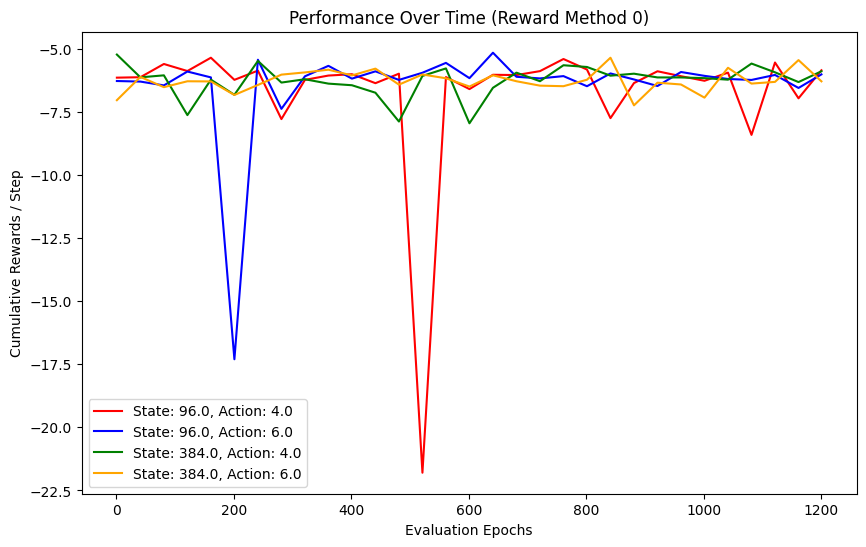

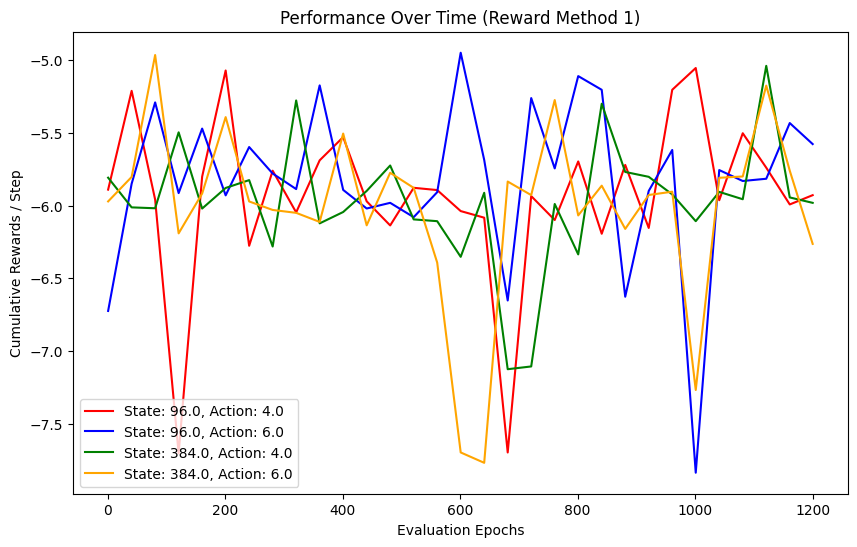

In [54]:
colors = {
    (96, 4): 'red',
    (96, 6): 'blue',
    (384, 4): 'green',
    (384, 6): 'orange'
}

# Reward methods
reward_methods = [0, 1]

for reward in reward_methods:
    plt.figure(figsize=(10, 6))

    for index, row in best_hyperparams[best_hyperparams['reward_method'] == reward].iterrows():
        state_size = row['state_size']
        action_size = row['action_size']
        lr = row['learning_rate']
        df = row['discount_factor']
        ed = row['epsilon_decay']

        # Construct the file name and load the data
        file_name = f"./Results/q-learning/lr{lr}_df{df}_ed{ed}_{int(state_size)}_{int(action_size)}_{int(reward)}.npy"
        data = np.load(file_name)

        # Plotting
        epochs = data[:, 0]
        cumulative_rewards = data[:, 1]
        plt.plot(epochs, cumulative_rewards, color=colors[(state_size, action_size)], label=f"State: {state_size}, Action: {action_size}")

    plt.xlabel("Evaluation Epochs")
    plt.ylabel("Cumulative Rewards / Step")
    plt.title(f"Performance Over Time (Reward Method {reward})")
    plt.legend()
    plt.show()

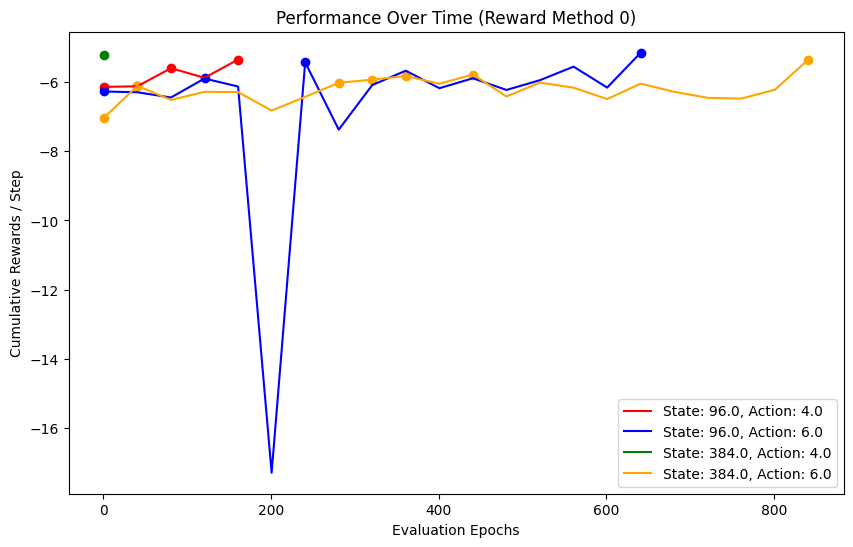

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming best_hyperparams is already defined and loaded
# Define colors for each state-action pair
colors = {
    (96, 4): 'red',
    (96, 6): 'blue',
    (384, 4): 'green',
    (384, 6): 'orange'
}

plt.figure(figsize=(10, 6))

# Filter for reward method 0
best_hyperparams_reward_0 = best_hyperparams[best_hyperparams['reward_method'] == 0]

for index, row in best_hyperparams_reward_0.iterrows():
    state_size = row['state_size']
    action_size = row['action_size']
    lr = row['learning_rate']
    df = row['discount_factor']
    ed = row['epsilon_decay']
    best_performance = row['cumulative_rewards_per_step']

    # Construct the file name and load the data
    file_name = f"./Results/q-learning/lr{lr}_df{df}_ed{ed}_{int(state_size)}_{int(action_size)}_0.npy"
    data = np.load(file_name)

    # Extract epochs and cumulative rewards
    epochs = data[:, 0]
    cumulative_rewards = data[:, 1]

    # Find the epoch where the best performance is first achieved or exceeded
    target_epoch_index = np.argmax(cumulative_rewards >= best_performance)
    if cumulative_rewards[target_epoch_index] < best_performance:
        target_epoch_index = len(epochs) - 1  # Use the full range if the target is not reached

    # Plotting only up to the target_epoch_index
    plt.plot(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1], color=colors[(state_size, action_size)], label=f"State: {state_size}, Action: {action_size}")

    # Mark improvements
    last_best_performance = float('-inf')
    for epoch, reward in zip(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1]):
        if reward > last_best_performance:
            plt.scatter(epoch, reward, color=colors[(state_size, action_size)], marker='o')
            last_best_performance = reward

plt.xlabel("Evaluation Epochs")
plt.ylabel("Cumulative Rewards / Step")
plt.title("Performance Over Time (Reward Method 0)")
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './Results/q-learning/lr0.05_df0.85_ed0.99_96_6_-5.npy'

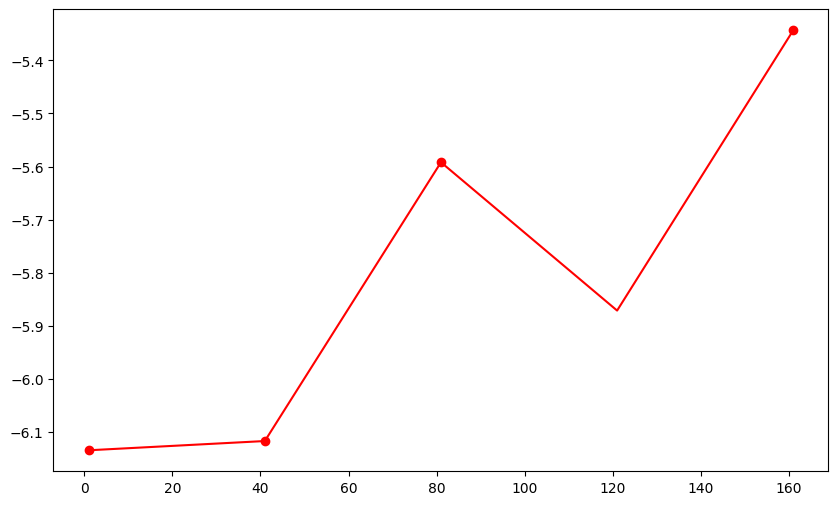

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define colors for each state-action pair
colors = {
    (96, 4): 'red',
    (96, 6): 'blue',
    (384, 4): 'green',
    (384, 6): 'orange'
}

plt.figure(figsize=(10, 6))

for index, row in best_hyperparams.iterrows():
    state_size = row['state_size']
    action_size = row['action_size']
    lr = row['learning_rate']
    df = row['discount_factor']
    ed = row['epsilon_decay']
    best_performance = row['cumulative_rewards_per_step']

    # Construct the file name and load the data
    file_name = f"./Results/q-learning/lr{lr}_df{df}_ed{ed}_{int(state_size)}_{int(action_size)}.npy"
    data = np.load(file_name)

    # Extract epochs and cumulative rewards
    epochs = data[:, 0]
    cumulative_rewards = data[:, 1]

    # Find the epoch where the best performance is first achieved or exceeded
    target_epoch_index = np.argmax(cumulative_rewards >= best_performance)
    if cumulative_rewards[target_epoch_index] < best_performance:
        target_epoch_index = len(epochs) - 1  # Use the full range if the target is not reached

    # Plotting only up to the target_epoch_index
    plt.plot(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1], color=colors[(state_size, action_size)], label=f"State: {state_size}, Action: {action_size}")

    # Mark improvements
    last_best_performance = float('-inf')
    for epoch, reward in zip(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1]):
        if reward > last_best_performance:
            plt.scatter(epoch, reward, color=colors[(state_size, action_size)], marker='o')
            last_best_performance = reward

plt.xlabel("Evaluation Epochs")
plt.ylabel("Cumulative Rewards / Step")
plt.title("Performance Over Time")
plt.legend()
plt.show()


In [ ]:
Running training 5/8 with learning rate=0.01, discount factor=0.85, epsilon decay=0.995. state size=96, Action siz=4
Running training 2/8 with learning rate=0.05, discount factor=0.85, epsilon decay=0.99. state size=384, Action siz=4